# 🧑‍🎓 Students:

- Diyun LU
- Marwan MASHRA
- Yihan ZHONG

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random, os, math
import matplotlib.pyplot as plt 
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# [IGNORE THIS] Adam16: this is just to be able to use half precision for the weights of the LSTM model and make it faster, Adam16 helps avoiding the nan loss
class Adam16(torch.optim.Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        params = list(params)
        super(Adam16, self).__init__(params, defaults)
        # for group in self.param_groups:
            # for p in group['params']:
        
        self.fp32_param_groups = [p.data.float().cuda() for p in params]
        if not isinstance(self.fp32_param_groups[0], dict):
            self.fp32_param_groups = [{'params': self.fp32_param_groups}]

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group,fp32_group in zip(self.param_groups,self.fp32_param_groups):
            for p,fp32_p in zip(group['params'],fp32_group['params']):
                if p.grad is None:
                    continue
                    
                grad = p.grad.data.float()
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], fp32_p)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
            
                # print(type(fp32_p))
                fp32_p.addcdiv_(exp_avg, denom, value=-step_size)
                p.data = fp32_p.half()

        return loss

# Lab exercise: neural language modeling

The goal of this lab exercise is build two neural language models:
- a neural n-gram model based on a simple MLP
- an autoregressive model based on a LSTM

Although the n-gram model is straighforward to code, there are a few "tricks" that you need to implement for the autoregressive model:
- word dropout
- variational dropout
- loss function masking

## Variational dropout

The idea of variational dropout is to apply the same mask at each position for a given sentence (if there are several sentences in a minibatch, use different masks for each input).
The idea is as follows:
- assume a sentence of n words whose embeddings are e_1, e_2, ... e_n
- at the input of the LSTM, instead of apply dropout independently to each embedding, sample a single mask that will be applied similarly at each position
- same at the output of the LSTM

See Figure 1 of this paper: https://proceedings.neurips.cc/paper/2016/file/076a0c97d09cf1a0ec3e19c7f2529f2b-Paper.pdf

To implement this, you need to build a custom module that applies the dropout only if the network is in training mode.

## Data preprocessing

You first need to download the Penn Treebank as pre-processed by Tomas Mikolov. It is available here: https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/tree/master/data
We will use the following files:
- ptb.train.txt
- ptb.valid.txt
- ptb.test.txt

Check manually the data.

Todo:
- build a word dictionnary, i.e. a bijective mapping between words and integers. You will need to add a special token "\<BOS\>" to the dictionnary even if it doesn't appear in sentences. (if you want to generate data, you will also need a "\<EOS\>" token, but this is not a requirement for this lab exercise --- you can do this at the end if you want)
- build python list of integers representing each input. For example, for the sentence "I sleep", the tensor could look like [10, 5] if 10 is the integer associated with "I" and 5 the integer associated with "sleep". You can add this directly to the dictionnaries in \*\_data

In [42]:
def read_file(path):
    data = list()
    with open(path) as inf:
        for line in inf:
            line = line.strip()
            if len(line) == 0:
                continue
            data.append({"text": line.split()})
    return data

In [43]:
train_data = read_file("data/ptb.train.txt")
dev_data = read_file("data/ptb.valid.txt")
test_data = read_file("data/ptb.test.txt")

In [44]:
print(len(train_data), len(dev_data), len(test_data))
print("\n\n".join(" ".join(s["text"]) for s in train_data[:5]))

42068 3370 3761
aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter

pierre <unk> N years old will join the board as a nonexecutive director nov. N

mr. <unk> is chairman of <unk> n.v. the dutch publishing group

rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate

a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported


In [45]:
class WordDict:
    # constructor, words must be a set containing all words
    def __init__(self, words):
        assert type(words) == set
        self.words_dict = dict(zip(words, range(len(words))))
        self.index_dict = dict(zip(self.words_dict.values(),self.words_dict.keys()))

    # return the integer associated with a word
    def word_to_id(self, word):
        assert type(word) == str
        return self.words_dict[word] if word in self.words_dict else self.words_dict["<unk>"]
    
    # return the word associated with an integer
    def id_to_word(self, idx):
        assert type(idx) == int
        return self.index_dict[idx] if idx in self.index_dict else "<unk>"
    
    # number of word in the dictionnary
    def __len__(self):
        return len(self.words_dict)

In [46]:
train_words = set()
for sentence in train_data:
    train_words.update(sentence["text"])
train_words.update(["<bos>", "<eos>, <unk>"])
word_dict = WordDict(train_words)
len(word_dict)  # should be 10001

10001

In [8]:
sentence_to_id = lambda sentence: list(map(word_dict.word_to_id, sentence)) 
process_data = lambda data: list(map(sentence_to_id, [sentence['text'] for sentence in data] )) 
train_data_idx = process_data(train_data)
dev_data_idx = process_data(dev_data)
test_data_idx = process_data(test_data)

print(train_data_idx[0])

[7221, 940, 9337, 2418, 2310, 2535, 8713, 1846, 8704, 373, 8282, 2273, 2635, 569, 1011, 5694, 3510, 3023, 4293, 7651, 9291, 1877, 2033, 6674]


## Evaluation

For evaluation, you must compute the perplexity of the test dataset (i.e. assume the dataset is one very long sentence), see:
https://lena-voita.github.io/nlp_course/language_modeling.html#evaluation

Note that you don't need to explicitly compute the root, you can use log probabilities and properties of log functions for this.
As during evaluation, you will see sentences one after the other, you can code a small class to keep track of log probabilities of words and compute the global perplexity at the end.

In [8]:
class Perplexity:
    def __init__(self):
        self.log_probs = torch.tensor([]).to(device)


    def reset(self):
        self.log_probs = torch.tensor([]).to(device)

    def add_sentence(self, log_probs):
        # log_probs: vector of log probabilities of words in a sentence
        self.log_probs = torch.cat([self.log_probs, log_probs])

    def compute_perplexity(self):
        return 2**((-1/self.log_probs.size(0))*self.log_probs.sum())


## Neural n-gram model

The model must be similar to the one presented in the course notes.
Note that for training and testing, you can transform the data has a set of multiclass classification problems.

Todo:
1. transform the data into tensors --- note that you can decompose your data to have input tensors of shape 2 and a unique output, why ? You will need to pad the sentence with \<BOS\> tokens --- why do you need two before the first word?
2. train the network
3. compute perplexity of the test data

In [10]:
def create_ngrams(data, n=3):
    n -= 1
    bos_id = word_dict.word_to_id('<bos>')
    eos_id = word_dict.word_to_id('<eos>')
    x_array, y_array = [], []
    for sentence in data:
        sentence = [bos_id]*n + sentence
        for i in range(len(sentence)-n):
            x_array.append(sentence[i:i+n])
        y_array.extend(sentence[n:])
    x_tensor = torch.LongTensor(x_array)
    y_tensor = torch.LongTensor(y_array)
    return x_tensor, y_tensor

x_train, y_train = create_ngrams(train_data_idx, n=3)
x_dev, y_dev = create_ngrams(dev_data_idx, n=3)
x_test, y_test = create_ngrams(test_data_idx, n=3)

x_train = x_train.to(device)
y_train = y_train.to(device)
x_dev = x_dev.to(device)
y_dev = y_dev.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_train

tensor([[6173, 6173],
        [6173, 7046],
        [7046, 2773],
        ...,
        [5196, 1682],
        [1682, 2308],
        [2308, 1469]], device='cuda:0')

In [69]:
class nGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=10, context_size=2):
        super(nGramModel, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_size = context_size
        self.hidden_dim = hidden_dim
        self.emb_table = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(self.embedding_dim *
                      self.context_size, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.vocab_size),
        ).to(device)

    def forward(self, inputs):
        emb = self.emb_table(inputs).reshape((inputs.shape[0], -1)).to(device)
        logits = self.mlp(emb)
        log_probs = F.log_softmax(logits, dim=1)
        return log_probs

    def predict(self, inputs):
        log_probs = self.forward(inputs)
        y_pred =  log_probs.argmax(dim=1)
        return y_pred

    def evaluate(self, x, y, data_name="data", batch_size=256):
        self.eval()
        perplexity = Perplexity()
        with torch.no_grad():
            for i in range(0, x.shape[0], batch_size):
                batch = x[i:i + batch_size]
                log_probs = self.forward(batch)
                gold = y[i:i + batch_size]
                log_probs_gold = log_probs[range(0,gold.shape[0]),gold]
                perplexity.add_sentence(log_probs_gold)
        prep = perplexity.compute_perplexity()
        perplexity.reset()
        print(f'perplexity on {data_name} : {prep:.3f}')
        return prep


embedding_dim = 64
vocab_size = len(word_dict)
ngram = nGramModel(vocab_size=vocab_size, embedding_dim=embedding_dim).to(device)
inputs = x_train[:5]
log_probs = ngram(inputs)
print(ngram.predict(inputs))


ngram.evaluate(x_train, y_train, data_name="x_train")

tensor([2162, 7803, 8322, 8970, 8989], device='cuda:0')
perplexity on x_train : 595.204


tensor(595.2043, device='cuda:0')

In [87]:
def shuffle_two_arrays(a, b):
    assert len(a) == len(b)
    p = torch.randperm(len(a))
    return a[p], b[p]

def train(model, n_epoch=200, batch_size=256, optimizer=Adam16, lr=1e-3, early_stopping=True, early_stopping_limit=2, save_plot=False, x_train=x_train, y_train=y_train, x_dev=x_dev, y_dev=y_dev, x_test=x_test, y_test=y_test):
    early_stopping_limit = early_stopping_limit
    dev_loss_up = 0
    my_optimizer = optimizer(model.parameters(), lr=lr)
    loss_train = list()
    loss_dev = list()
    loss_function = nn.NLLLoss()
    for epoch in range(n_epoch):
        model.train()
        # shuffle
        x_train, y_train = shuffle_two_arrays(x_train, y_train)
        losses_train = list()
        counter = 0
        for i in range(0, x_train.shape[0], batch_size):
            my_optimizer.zero_grad()
            batch = x_train[i:i+batch_size]
            gold = y_train[i:i+batch_size]
            log_probs = model(batch)
            loss = loss_function(log_probs, gold)
            losses_train.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            my_optimizer.step()
            print(f"batch {counter}/{int(x_train.shape[0]/batch_size)}", end='\r', flush=True)
            counter += 1
        mean_train_loss = sum(losses_train)/len(losses_train)
        loss_train.append(mean_train_loss)
        losses_dev = []
        model.eval()
        with torch.no_grad():
            for i in range(0, x_dev.shape[0], batch_size):
                try:
                    dev_batch = x_dev[i:i + batch_size]
                    dev_labels = y_dev[i:i + batch_size]
                    dev_loss = loss_function(model(dev_batch), dev_labels)
                    losses_dev.append(dev_loss.item())
                except:
                    print("batch", batch.shape)
                    continue
                    
        mean_dev_loss = sum(losses_dev) / len(losses_dev)
        loss_dev.append(mean_dev_loss)
        print(f"{epoch+1}) train_loss: {mean_train_loss:.3f}  dev_loss: {mean_dev_loss:.3f}  ")

        if early_stopping: 
            if len(loss_dev)>5 and loss_dev[-1]>=loss_dev[-2]:
                dev_loss_up += 1
            else:
                dev_loss_up = 0
            if dev_loss_up==early_stopping_limit:
                print(f"Preformed {epoch+1} epochs")
                break

    # evaluation
    prep_train = model.evaluate(x_train, y_train, data_name="train")
    prep_dev = model.evaluate(x_dev, y_dev, data_name="dev")
    prep_test = model.evaluate(x_test, y_test, data_name="test")
    prep_model = f'train={prep_train:.1f}, dev={prep_dev:.1f}, test={prep_test:.1f}'

    plt.plot(torch.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
    plt.plot(torch.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
    plt.legend()
    title =  f"optimizer={optimizer.__name__}, lr={lr} \n perplexity on ({prep_model})"
    plt.title(title)
    if save_plot:
        os.makedirs("plots",exist_ok=True)
        plt.savefig(f'plots/{title}.png')
    plt.show()

1) train_loss: 6.982  dev_loss: 6.341  
2) train_loss: 6.179  dev_loss: 6.061  
3) train_loss: 5.953  dev_loss: 5.905  
4) train_loss: 5.812  dev_loss: 5.812  
5) train_loss: 5.717  dev_loss: 5.752  
6) train_loss: 5.647  dev_loss: 5.712  
7) train_loss: 5.594  dev_loss: 5.685  
8) train_loss: 5.552  dev_loss: 5.667  
9) train_loss: 5.519  dev_loss: 5.655  
10) train_loss: 5.492  dev_loss: 5.650  
11) train_loss: 5.470  dev_loss: 5.650  
12) train_loss: 5.453  dev_loss: 5.656  
13) train_loss: 5.440  dev_loss: 5.671  
Preformed 13 epochs
perplexity on train : 42.411
perplexity on dev : 50.970
perplexity on test : 47.629


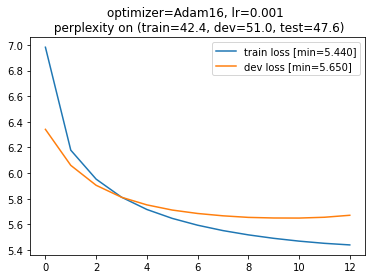

In [89]:
trigram = nGramModel(vocab_size=vocab_size, embedding_dim=embedding_dim).half().to(device)
train(trigram, n_epoch=200, batch_size=1024)

## LSTM model

This model should rely on a LSTM.

1. transform the data into tensors => you can't use the same trick as for the n-gram model
2. train the network by batching the input --- be very careful when computing the loss function! And explain how to batch data, compute the loss with batch data, etc, in the report!
3. compute the perplexity on the test data
4. implement variational dropout at input and output of the LSTM

Warning: you need to use the option batch_first=True for the LSTM.

In [10]:
def to_list_tensors(data): 
    return list(map(lambda x: torch.LongTensor(x).to(device), data))

x_train = to_list_tensors(train_data_idx)
x_dev = to_list_tensors(dev_data_idx)
x_test = to_list_tensors(test_data_idx)
x_train[0].size()

torch.Size([24])

In [11]:
class VariationalDropout(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = dropout

        if dropout<0 or dropout>1:
            print("Warning: Dropout should be >0 and <1")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.dropout <= 0. or self.dropout > 1.:
            return x
        batch_size, num_words, emb_dim = x.size()
        m = x.new_empty(batch_size, 1, emb_dim, requires_grad=False).bernoulli_(1 - self.dropout)
        x = (x*m) / (1 - self.dropout)
        return x

In [12]:
class LSTM_MODEL(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=10, hidden_size=10, context_size=3, num_layers=1, dropout=0.0):
        super(LSTM_MODEL, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_size = context_size
        self.hidden_dim = hidden_dim
        self.hidden_size = hidden_size
        self.emb_table = nn.Embedding(
            self.vocab_size+1, self.embedding_dim, padding_idx=self.vocab_size)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True).to(device)  # lstm
        self.dropout = VariationalDropout(dropout)
        self.mlp = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.vocab_size),
        ).to(device)

    def forward(self, inputs):
        w = torch.empty(len(inputs), max(len(s) for s in inputs), dtype=torch.long).to(device)
        w.fill_(self.emb_table.padding_idx)
        for i,input in enumerate(inputs):
            w[i,:input.shape[0]] = input
        embs = self.emb_table(w)
        embs = self.dropout(embs)
        self.lstm.flatten_parameters()   # to avoid a warning
        output, _ = self.lstm(embs)
        output = self.dropout(output)
        logits = self.mlp(output)
        log_probs = F.log_softmax(logits, dim=1)
        list_log_probs = []
        for i in range(log_probs.shape[0]):
            list_log_probs.append(log_probs[i, :(inputs[i].shape[0])])
        return list_log_probs

    def evaluate(self, data, data_name="data", batch_size=256):
        perplexity = Perplexity()
        self.eval()
        with torch.no_grad():
            for i in range(0, len(data), batch_size):
                batch = data[i:i + batch_size]
                gold = torch.cat(batch)
                list_log_probs = self.forward(batch)
                log_probs = torch.cat(list_log_probs)
                log_probs_gold = log_probs[range(0,gold.shape[0]),gold]
                perplexity.add_sentence(log_probs_gold)
        prep = perplexity.compute_perplexity()
        perplexity.reset()
        print(f'perplexity on {data_name} : {prep:.3f}')
        return prep

embedding_dim = 64
vocab_size = len(word_dict)
lstm_model = LSTM_MODEL(vocab_size=vocab_size, embedding_dim=embedding_dim).half().to(device)
inputs = x_train[:5]
log_probs = lstm_model(inputs)

lstm_model.evaluate(x_train, data_name="train")

perplexity on train : 16.541


tensor(16.5412, device='cuda:0')

In [13]:
def train(model, n_epoch=200, batch_size=256, optimizer=Adam16, lr=1e-3, early_stopping=True, early_stopping_limit=2, save_plot=False, x_train=x_train, x_dev=x_dev, x_test=x_test):
    early_stopping_limit = early_stopping_limit
    dev_loss_up = 0
    my_optimizer = optimizer(model.parameters(), lr=lr)
    loss_train = list()
    loss_dev = list()
    loss_function = nn.NLLLoss()
    for epoch in range(n_epoch):
        model.train()
        losses_train = list()
        counter = 0
        for i in range(0, len(x_train), batch_size):
            my_optimizer.zero_grad()
            batch = x_train[i:i+batch_size]
            list_log_probs = model(batch)
            log_probs = torch.cat(list_log_probs)
            gold = torch.cat(batch)
            loss = loss_function(log_probs, gold)
            losses_train.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            my_optimizer.step()
            print(f"batch {counter}/{int(len(x_train)/batch_size)}", end='\r', flush=True)
            counter += 1
        mean_train_loss = sum(losses_train)/len(losses_train)
        loss_train.append(mean_train_loss)
        losses_dev = []

        model.eval()
        with torch.no_grad():
            for i in range(0, len(x_dev), batch_size):
                try:
                    batch = x_dev[i:i+batch_size]
                    list_log_probs = model(batch)
                    log_probs = torch.cat(list_log_probs)
                    dev_labels = torch.cat(batch)
                    dev_loss = loss_function(log_probs, dev_labels)
                    losses_dev.append(dev_loss.item())
                except:
                    print("batch", len(batch))
                    continue
                    
        mean_dev_loss = sum(losses_dev) / len(losses_dev)
        loss_dev.append(mean_dev_loss)
        print(f"{epoch+1}) train_loss: {mean_train_loss:.3f}  dev_loss: {mean_dev_loss:.3f}  ")

        if early_stopping: 
            if len(loss_dev)>5 and loss_dev[-1]>=loss_dev[-2]:
                dev_loss_up += 1
            else:
                dev_loss_up = 0
            if dev_loss_up==early_stopping_limit:
                print(f"Preformed {epoch+1} epochs")
                break

    # evaluation
    prep_train = model.evaluate(x_train, data_name="train")
    prep_dev = model.evaluate(x_dev, data_name="dev")
    prep_test = model.evaluate(x_test, data_name="test")
    prep_model = f'train={prep_train:.1f}, dev={prep_dev:.1f}, test={prep_test:.1f}'


    plt.plot(torch.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
    plt.plot(torch.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
    plt.legend()
    title =  f"optimizer={optimizer.__name__}, lr={lr} \n perplexity on ({prep_model})"
    plt.title(title)
    if save_plot:
        os.makedirs("plots",exist_ok=True)
        plt.savefig(f'plots/{title}.png')
    plt.show()

1) train_loss: 4.011  dev_loss: 3.891  
2) train_loss: 3.756  dev_loss: 3.491  
3) train_loss: 3.424  dev_loss: 3.145  
4) train_loss: 3.145  dev_loss: 2.874  
5) train_loss: 2.945  dev_loss: 2.695  
6) train_loss: 2.809  dev_loss: 2.561  
7) train_loss: 2.706  dev_loss: 2.459  
8) train_loss: 2.629  dev_loss: 2.383  
9) train_loss: 2.577  dev_loss: 2.326  
10) train_loss: 2.532  dev_loss: 2.283  
11) train_loss: 2.497  dev_loss: 2.249  
12) train_loss: 2.468  dev_loss: 2.221  
13) train_loss: 2.440  dev_loss: 2.197  
14) train_loss: 2.422  dev_loss: 2.176  
15) train_loss: 2.406  dev_loss: 2.158  
16) train_loss: 2.389  dev_loss: 2.142  
17) train_loss: 2.370  dev_loss: 2.128  
18) train_loss: 2.363  dev_loss: 2.113  
19) train_loss: 2.350  dev_loss: 2.100  
20) train_loss: 2.337  dev_loss: 2.086  
perplexity on train : 4.267
perplexity on dev : 4.251
perplexity on test : 4.268


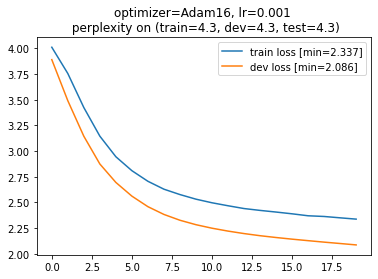

In [15]:
model = LSTM_MODEL(vocab_size=vocab_size, embedding_dim=32, hidden_size=3, hidden_dim=3, dropout=0.3).half().to(device)
train(model, n_epoch=20)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=510eed3f-cfe8-4b8a-9785-d4723865ac9d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>